In [1]:
import os, sys
sys.path.append(os.path.expanduser(os.path.join("~", "Projects", "birkhoff")))
sys.path.append('/Users/Cybele/GIT/birkhoff/birkhoff/')
sys.path.append('/Users/Cybele/GIT/birkhoff/src/')
sys.path.append('/Users/Cybele/GIT/birkhoff/')

import numpy as np
from scipy.misc import logsumexp
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import timeit

from birkhoff.primitives import gaussian_logp

In [2]:
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("paper")

from scipy.optimize import linear_sum_assignment

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.optimizers import adam


In [3]:
# Global parameters
npr.seed(0)
K = 100
D = 2
eta = 0.5
sigma_min, sigma_max = 1e-8, 1.0

# Optimization parameters
num_adam_iters = 1
num_mcmc_samples = 1

# Sample a true permutation (in=col, out=row)
# perm_true = npr.permutation(K)
perm_true = np.arange(K)[::-1]
#perm_true = np.arange(K)
P_true = np.zeros((K, K))
P_true[np.arange(K), perm_true] = 1

# Sample data according to this permutation
xs = npr.randn(K, D)*10
xs_perm = P_true.T.dot(xs)
ys = xs_perm + eta * npr.randn(K, D)


M = np.ones((K,K))
M2 = np.zeros((K,K))
listchar = npr.choice(K, K,replace= False)
#listchar =[]

for m in listchar:
    i = np.where(P_true[m,:] ==1)[0]
    #M[m, [j for j in range(K) if j not in [i]]] = 1e-8
    random = npr.choice(K,80, replace = False)
    M[m, [j for j in random if j not in [i]]] = 1e-8
    M2[m, [j for j in random if j not in [i]]] = 100000000000
    #print (i, random) 
    #print 
    #M[[j for j in range(K) if j not in [i]],m]=1e-8
#print len(np.where(M.flatten()==1)[0])
#M = np.dot(P_true.T, np.dot(deepcopy(M),P_true))


([], <a list of 0 Text yticklabel objects>)

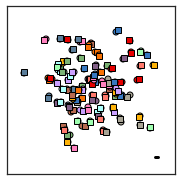

In [4]:
# Plot to and from
fig = plt.figure(figsize=(3,3))
lim = max(abs(ys).max(), abs(xs).max())
for k in range(K):
    plt.plot(xs[k, 0], xs[k, 1], 'o',
             color=colors[k % len(colors)],  markersize=6,
             markeredgecolor='k', markeredgewidth=1)
    plt.plot(ys[perm_true[k], 0], ys[perm_true[k], 1], 's',
             markersize=6, color=colors[k % len(colors)],
             markeredgecolor='k', markeredgewidth=1)

# Scale bar
plt.plot([lim-2*eta,lim], [-lim,-lim], '-k', lw=3)

plt.xlim([-1.25*lim, 1.25*lim])
plt.ylim([-1.25*lim, 1.25*lim])
plt.xticks([])
plt.yticks([])

In [19]:
# Compute the MAP assignment
score = np.zeros((K, K))
for i in range(K):
    for j in range(K):
#         score[i,j] = -0.5 * np.sum((ys[j] - xs[i])**2) / eta**2 
        score[i,j] = np.sum(gaussian_logp(ys[j], xs[i], eta))
row, col = linear_sum_assignment(-score)
P_map = np.zeros((K, K))
P_map[row, col] = 1
start_time = timeit.default_timer()

round_to_perm(npr.randn(300,300))
elapsed = timeit.default_timer() - start_time
print elapsed

1.02431607246


In [20]:
# Build variational objective. The variational dist is 
# a diagonal Gaussian over the (K-1)**2 parameters


# Build variational objective. The variational dist is 
# a diagonal Gaussian over the (K-1)**2 parameters
limits = np.zeros((2,2))
limits[0,0] = -5
limits[0,1] = 5
limits[1,0] = 0.00
limits[1,1] = 0.01
# Set up the log probability objective
# Assume a uniform prior on P?
# Right now this is just the likelihood...
def perm_to_P(perm):
        K=len(perm)
        P = np.zeros((K,K))
        P[range(K),perm] = 1 
        return P

def round_to_perm(P):
    from scipy.optimize import linear_sum_assignment
    K = P.shape[0]
    
    assert P.shape == (K, K)
    row, col = linear_sum_assignment(-P)
    P = np.zeros((K, K))
    P[row, col] = 1.0
    return P

def unpack_params_sparse(params, K, M):
    indexes = np.where(M.flatten() == 1)
    logit_mu = []
    logit_sigma = []
    #logit_mu = np.zeros(K*K)
    #logit_sigma = np.zeros(K*K)
    #logit_mu[indexes[0]] = params[:n_params]
    #logit_sigma[indexes[0]] = params[n_params:]
    cont = 0
    
    for i in range(K*K):
        if i in indexes[0]:
            logit_mu.append(params[:n_params][cont])
            logit_sigma.append(params[n_params:][cont])
            cont+=1
        else:
            logit_mu.append(0)
            logit_sigma.append(1)
    #return unpack_params(params,K)
    return np.reshape(np.array(logit_mu),(K,K)), np.reshape(np.array(logit_sigma),(K,K))
    #return (logit_mu, logit_sigma)

def logit(pi): return np.log(pi) - np.log(1-pi)
def logistic(psi): return np.exp(psi)/(1+np.exp(psi))

def rowwise_softmax(psi):
    
    maxes = np.amax(psi, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(psi - maxes)
    dist = (e.T / np.sum(e, axis=1)).T
    return dist

def columnwise_softmax(psi):
    
    maxes = np.amax(psi, axis=0)
    maxes = maxes.reshape(1, maxes.shape[0])
    e = np.exp(psi - maxes)
    dist = (e/ np.sum(e, axis=0))
    return dist


def sample_to_pi(sample, temp):
    
    start_time = timeit.default_timer()
    
    #s = sample * temp + (1 - temp) * round_to_perm(sample - M2) 
    #s = sample * temp + (1 - temp) * round_to_perm(sample )
    s = sample
    elapsed = timeit.default_timer() - start_time
    print elapsed
    return s
    
    # code you want to evaluate
  
    
    #return sample

def sample_pi_voronoi(params, noise,  temp, limits, M):
   
    K = noise.shape[1]
    
    logit_mu, logit_sigma = unpack_params_sparse(params, K, M)
    
    mu = np.exp(logit_mu*M)
    
    for j in range(5):
        
        mu = rowwise_softmax(np.log(mu*M))
        mu = columnwise_softmax(np.log(mu*M))
    
    sigma = limits[1, 0] + (limits[1, 1] - limits[1, 0]) * logistic(logit_sigma)
    
    sample = noise * sigma + mu
    
    
    return (sample, np.array([sample_to_pi(sample[i,:,:], temp) for i in range(sample.shape[0])]))
    
def log_density_gaussian_voronoi(params, temp, limits, K):
    
    logit_mu, logit_sigma = unpack_params_sparse(params,  K, M)
    
    sigma = limits[1, 0] + (limits[1, 1] - limits[1, 0]) * logistic(logit_sigma)
    log_sigma =np.log(sigma)
    entropy = 0.5 * log_sigma.size * (1.0 + np.log(2 * np.pi)) + np.sum(log_sigma)
    
    return entropy + K *(K) * np.log(temp)

# Set up the log probability objective
# Assume a uniform prior on P?
# Right now this is just the likelihood...
def log_prob(P, t):
    return np.sum(gaussian_logp(ys, np.dot(P.T, xs), eta))
    
    
def variational_objective(params, t, K, M):
    
    """Provides a stochastic estimate of the variational lower bound."""
    #noise = npr.randn(num_mcmc_samples, K, K)
    noise = npr.randn(num_mcmc_samples, K, K)
    logit_mu, logit_sigma = unpack_params_sparse(params,  K, M)
    
    
    
    # code you want to evaluate
  
    (samples, P_samples) = sample_pi_voronoi(params, noise, temperature(t), limits, M)
    
    
    elbo = 0
    
    for P in P_samples:
        elbo = elbo + log_prob(P,t) / num_mcmc_samples 
        
    elbo = elbo + log_density_gaussian_voronoi(params, temperature(t), limits, K)
        
    return [-elbo, log_prob(P_samples[0],t),log_density_gaussian_voronoi(params, temperature(t), limits, K)]
 
def callback(params, t, g, perline=10):
    
    num_mcmc_samples = 1
    elbos.append(variational_objective(params, t, K, M))
    params_all.append(params)
    
    """Provides a stochastic estimate of the variational lower bound."""
    def n_correct(P1,P2):
        return P1.shape[0]- np.sum(np.abs(P1-P2))/2.0

    
    if (t % perline) == 0:
        sys.stdout.write('. [Iter {0}/{1}] VLB: {2:.1f}\n'.format(t, num_adam_iters, -elbos[-1][0]))
        print elbos[-1]
        noise = npr.randn(num_mcmc_samples, K, K)
        (sample, P_samples) = sample_pi_voronoi(params, noise, temperature(t), limits, M)
    
        perm_inferred = linear_sum_assignment(-P_samples[0])
        P_inf =perm_to_P(np.array(perm_inferred[1]))
        print [log_prob(P_samples[0],5), log_prob(P_inf,5), log_prob(P_true,5), n_correct(P_true,P_inf)]
       
    else:
        sys.stdout.write('.')
    sys.stdout.flush()
    




Variational inference for matching...
Initializing with MAP estimate
2079
9.53674316406e-07
0.0
. [Iter 0/300] VLB: -171151.9
[171151.93697825249, -40450.045636928786, -130701.8913413237]
0.0
[-40931.514133852717, -88167.102471165941, -135.77063693254146, 7.0]
9.53674316406e-07
9.53674316406e-07
.9.53674316406e-07
0.0
.1.90734863281e-06
1.19209289551e-06
.9.53674316406e-07
9.53674316406e-07
.9.53674316406e-07
1.19209289551e-06
.9.53674316406e-07
1.19209289551e-06
.9.53674316406e-07
1.19209289551e-06
.0.0
9.53674316406e-07
.9.53674316406e-07
0.0
.0.0
9.53674316406e-07
. [Iter 10/300] VLB: -154192.6
[154192.5896639351, -23922.345051293662, -130270.24461264143]
9.53674316406e-07
[-23768.015760255192, -20515.847974177439, -135.77063693254146, 19.0]
9.53674316406e-07
0.0
.9.53674316406e-07
9.53674316406e-07
.1.19209289551e-06
9.53674316406e-07
.1.19209289551e-06
0.0
.9.53674316406e-07
9.53674316406e-07
.0.0
0.0
.0.0
9.53674316406e-07
.0.0
9.53674316406e-07
.0.0
1.19209289551e-06
.0.0
9.5367

KeyboardInterrupt: 

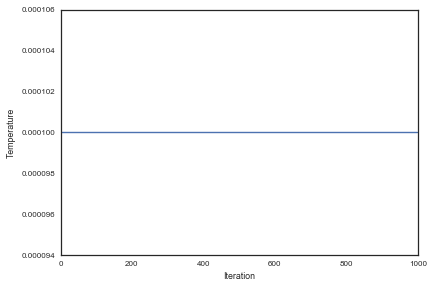

In [21]:
print("Variational inference for matching...")
print("Initializing with MAP estimate")
# Global parameters
npr.seed(0)

def temperature(i):
    tau0=0.00001
    MIN_TEMP = 0.0001
    ANNEAL_RATE = 0.1
    np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    return np_temp

t = np.arange(1000)
plt.plot(t, temperature(t))
plt.xlabel("Iteration")
plt.ylabel("Temperature")

sigma_min, sigma_max = 1e-8, 1.0
num_adam_iters = 300
num_mcmc_samples = 1
indexes = np.where(M.flatten() ==1)

n_params = len(indexes[0])

init_mean = -10*np.ones(n_params)
#print init_mean.shape
print n_params
init_logit_std = -5*npr.randn(n_params)
init_var_params = np.concatenate([init_mean, init_logit_std])
#print init_var_params.shape
elbos=[]
# SGD with Adam

var_objective = lambda x,t: variational_objective(x, t, K, M)[0]
gradient = grad(var_objective)
elbos = []
params_all =[]

variational_params = adam(gradient, init_var_params, step_size=0.05, num_iters=num_adam_iters, callback=callback)


# SGD with Adam



In [ ]:
# Plot the elbo
plt.figure(figsize=(6,4))
plt.plot(elbos)
plt.xlim(0, num_adam_iters)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.tight_layout()

In [ ]:
# Sample from the posterior and show samples
q_mu, _, q_sigma = unpack_params(variational_params)

lim = max(abs(ys).max(), abs(xs).max())

fig = plt.figure(figsize=(10, 10), facecolor='white')
for i in range(4):
    for j in range(4):
        Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
        P_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
        # Round doubly stochastic matrix P to the nearest permutation matrix
        row, col = linear_sum_assignment(-P_sample)
        
        if (i == 0) and (j == 0):
            col = np.argmax(P_true, axis=1)

        ax = fig.add_subplot(4, 4, i*4 + j +1, frameon=True)
        for k in range(K):
            plt.plot(ys[k, 0], ys[k, 1], 'sk', markersize=8)
            plt.plot(xs[k, 0], xs[k, 1], 'ok', markersize=8)

        for k in range(K):
            plt.plot(xs[k, 0], xs[k, 1], 'o',
                     color=colors[k % len(colors)],  markersize=6)
            plt.plot(ys[col[k], 0], ys[col[k], 1], 's',
                     markersize=6, color=colors[k % len(colors)])

        # Scale bar
        plt.plot([lim-2*eta,lim], [-lim,-lim], '-k', lw=3)

        ax.set_xlim([-1.25*lim, 1.25*lim])
        ax.set_ylim([-1.25*lim, 1.25*lim])
        ax.set_xticks([])
        ax.set_yticks([])
        
        if (i==0) and (j==0):
            ax.set_title("True")
        else:
            ax.set_title("Sample {}".format(i*4+j+1))

plt.tight_layout()

In [ ]:
# Enumerate all possible permutations and compute their probability
if K < 7:
    Kfac = np.prod(np.arange(1, K+1))

    post_true = {}
    import itertools as it
    for perm in it.permutations(np.arange(K)):
        P = np.zeros((K, K))
        P[np.arange(K), perm] = 1
        post_true[perm] = log_prob(P, 0)

    post_inf = {}
    for perm in it.permutations(np.arange(K)):
        post_inf[perm] = 0

    N_sample = 1000
    for s in range(N_sample):
        Psi_sample = q_mu + npr.randn(K - 1, K - 1) * sigma_post
        P_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
        # Round doubly stochastic matrix P to the nearest permutation matrix
        row, col = linear_sum_assignment(-P_sample)
        post_inf[tuple(col)] += 1

    # Convert to arrays
    post_true_vec = np.zeros(Kfac)
    post_inf_vec = np.zeros(Kfac)
    for i, perm in enumerate(it.permutations(np.arange(K))):
        post_true_vec[i] = post_true[perm]
        post_inf_vec[i] = post_inf[perm]

    from scipy.misc import logsumexp
    post_true_vec = np.exp(post_true_vec - logsumexp(post_true_vec))
    post_inf_vec = post_inf_vec / post_inf_vec.sum()
    sort = np.argsort(-post_true_vec)
    post_true_vec = post_true_vec[sort]
    post_inf_vec = post_inf_vec[sort]

    trunc = 20
    trunc_post_true_vec = np.concatenate((post_true_vec[:trunc], 
                                          [post_true_vec[trunc:].sum()]))

    trunc_post_inf_vec = np.concatenate((post_inf_vec[:trunc], 
                                         [post_inf_vec[trunc:].sum()]))

    plt.figure(figsize=(4,2))
    plt.bar(np.arange(trunc+1), trunc_post_true_vec, width=0.4, color=colors[0], label="true")
    plt.bar(np.arange(trunc+1)+0.4, trunc_post_inf_vec, width=0.4, color=colors[1], label="inf")
    plt.legend(loc="upper right")
    plt.xlim(0, trunc+1)

else:
    print("Can only empirically compute exact permutation probability for small K")

In [ ]:
class_inf = np.zeros((K, K))

N_sample = 1000
for s in range(N_sample):
    Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
    B_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
    P_sample = birkhoff_to_perm(B_sample)
    class_inf += P_sample

class_inf /= float(N_sample)
    
fig = plt.figure(figsize=(6.5,2.))
ax1 = plt.subplot(141)
im1 = plt.imshow(P_true, interpolation="nearest")
plt.title("True permutation")

divider = make_axes_locatable(ax1)
cb1 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb1)
plt.colorbar(im1, cax=cb1)

ax2 = plt.subplot(142)
im2 = plt.imshow(P_map, interpolation="nearest")
plt.title("MAP Permutation")

divider = make_axes_locatable(ax2)
cb2 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb2)
plt.colorbar(im2, cax=cb2)

ax3 = plt.subplot(143)
im3 = plt.imshow(class_inf, vmin=0, vmax=1, interpolation="nearest")
ax3.set_title("$\mathrm{E}_{q(P)}[\mathrm{round}(P)]$")

divider = make_axes_locatable(ax3)
cb3 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb3)
plt.colorbar(im3, cax=cb3)

ax4 = plt.subplot(144)
im4 = plt.imshow(np.exp(score), interpolation="nearest",cmap="Blues")
ax4.set_title("$p(y_j \\mid x_i, \\eta)$")

divider = make_axes_locatable(ax4)
cb4 = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cb4)
plt.colorbar(im4, cax=cb4)

plt.tight_layout(pad=0.5)

plt.savefig("matching.pdf")
plt.savefig("matching.png", dpi=300)

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(q_mu, interpolation="none", 
           vmin=-abs(q_mu).max(), 
           vmax=abs(q_mu).max(), 
           cmap="RdBu")
plt.title("q mean")
plt.colorbar()

plt.subplot(122)
plt.imshow(q_sigma, interpolation="none")
plt.title("q variance")
plt.colorbar()


                 

In [ ]:
print("log p(y | x, P_{true}):       ", log_prob(P_true, 0))
print("log p(y | x, P_{map}):        ", log_prob(P_map, 0))

q_probs = []
for s in range(N_sample):
    Psi_sample = q_mu + npr.randn(K - 1, K - 1) * q_sigma
    B_sample = psi_to_birkhoff(logistic(Psi_sample / temperature(num_adam_iters)))
    P_sample = birkhoff_to_perm(B_sample)
    q_probs.append(log_prob(P_sample, 0))
q_probs = np.array(q_probs)

print("log E_{q(P)} [p(y | x, P)]:   ", -np.log(N_sample) + logsumexp(q_probs))
print("min_{P~q(P)} log p(y | x, P): ", np.min(q_probs))
print("max_{P~q(P)} log p(y | x, P): ", np.max(q_probs))

In [ ]:
plt.hist(q_probs / K**2, 40, color=colors[1], label="P ~ q(P)")
yl = plt.ylim()
plt.plot(log_prob(P_true, 0) / K**2 * np.ones(2), yl, 
         c=colors[0], label="P_true")
plt.plot(log_prob(P_map, 0) / K**2 * np.ones(2), yl, 
         c=colors[2], label="P_MAP")
plt.ylim(yl)
plt.legend(loc="upper left")
plt.xlabel("$\\mathrm{log} \; p(y | x, P) / K^2 $")
plt.ylabel("count")